In [ ]:
%%shell
jupyter nbconvert --to html /PATH/TO/YOUR/NOTEBOOKFILE.ipynb

In [1]:
!gdown "https://drive.google.com/uc?id=19nJOZ6i-YchqfQx_oGwZgo0js9ZrJxY_"

Downloading...
From: https://drive.google.com/uc?id=19nJOZ6i-YchqfQx_oGwZgo0js9ZrJxY_
To: /content/data immobilier.csv
100% 461k/461k [00:00<00:00, 30.7MB/s]


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from pylab import rcParams
rcParams['figure.figsize'] = (8.0, 6.0)

In [3]:

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

In [4]:
df=pd.read_csv("/content/data immobilier.csv")

In [5]:
df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,

In [6]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Feature ingeniering is alreadydone so we just add few manipulations 

### Pre-Processing



*  Here we want to convert all object variables to dummy variables, it will leads to 268 new binary features 




In [7]:
df_str=df.select_dtypes(object)
somme=0
dummy_variables=[]
for col in df_str.columns:
  somme+=len(df_str[f"{col}"].unique())
  if(len(df_str[f"{col}"].unique())>2):
      dummy_variables.append(col)
  else:
      df[col]=df[col].astype('category')
      df[col]=df[col].cat.codes
  print(f"{col} : " + str(len(df_str[f"{col}"].unique())))
print(f"somme : {somme}")

MSZoning : 5
Street : 2
Alley : 3
LotShape : 4
LandContour : 4
Utilities : 2
LotConfig : 5
LandSlope : 3
Neighborhood : 25
Condition1 : 9
Condition2 : 8
BldgType : 5
HouseStyle : 8
RoofStyle : 6
RoofMatl : 8
Exterior1st : 15
Exterior2nd : 16
MasVnrType : 5
ExterQual : 4
ExterCond : 5
Foundation : 6
BsmtQual : 5
BsmtCond : 5
BsmtExposure : 5
BsmtFinType1 : 7
BsmtFinType2 : 7
Heating : 6
HeatingQC : 5
CentralAir : 2
Electrical : 6
KitchenQual : 4
Functional : 7
FireplaceQu : 6
GarageType : 7
GarageFinish : 4
GarageQual : 6
GarageCond : 6
PavedDrive : 3
PoolQC : 4
Fence : 5
MiscFeature : 5
SaleType : 9
SaleCondition : 6
somme : 268


In [8]:
for dummy in dummy_variables:
  dum=pd.get_dummies(df[f"{dummy}"]).rename(columns=lambda x: "Category_" + str(x))
  df=pd.concat([df,dum],axis=1)
  df=df.drop(dummy,axis=1)

In [9]:
duplicate_columns = df.columns[df.columns.duplicated()]

In [10]:
df = df.loc[:,~df.columns.duplicated()]

In [11]:
df.head(10)

,Id,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,...,Category_Mix,Category_SBrkr,Category_Maj1,Category_Maj2,Category_Min1,Category_Min2,Category_Typ,Category_2Types,Category_Attchd,Category_Basment,Category_BuiltIn,Category_CarPort,Category_Detchd,Category_Fin,Category_RFn,Category_N,Category_P,Category_Y,Category_GdPrv,Category_GdWo,Category_MnPrv,Category_MnWw,Category_Gar2,Category_Othr,Category_TenC,Category_COD,Category_CWD,Category_Con,Category_ConLD,Category_ConLI,Category_ConLw,Category_New,Category_Oth,Category_WD,Category_Abnorml,Category_AdjLand,Category_Alloca,Category_Family,Category_Normal,Category_Partial
0,1,60,65.0,8450,1,0,7,5,2003,2003,196.0,706,0,150,856,1,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,...,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,1,0,6,8,1976,1976,0.0,978,0,284,1262,1,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,...,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,1,0,7,5,2001,2002,162.0,486,0,434,920,1,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,...,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,1,0,7,5,1915,1970,0.0,216,0,540,756,1,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,...,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,1,0,8,5,2000,2000,350.0,655,0,490,1145,1,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,...,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
5,6,50,85.0,14115,1,0,5,5,1993,1995,0.0,732,0,64,796,1,796,566,0,1362,1,0,1,1,1,1,5,0,1993.0,2,480,40,30,0,320,0,0,700,10,2009,...,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
6,7,20,75.0,10084,1,0,8,5,2004,2005,186.0,1369,0,317,1686,1,1694,0,0,1694,1,0,2,0,3,1,7,1,2004.0,2,636,255,57,0,0,0,0,0,8,2007,...,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
7,8,60,NaN,10382,1,0,7,6,1973,1973,240.0,859,32,216,1107,1,1107,983,0,2090,1,0,2,1,3,1,7,2,1973.0,2,484,235,204,228,0,0,0,350,11,2009,...,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
8,9,50,51.0,6120,1,0,7,5,1931,1950,0.0,0,0,952,952,1,1022,752,0,1774,0,0,2,0,2,2,8,2,1931.0,2,468,90,0,205,0,0,0,0,4,2008,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
9,10,190,50.0,7420,1,0,5,6,1939,1950,0.0,851,0,140,991,1,1077,0,0,1077,1,0,1,0,2,2,5,2,1939.0,1,205,0,4,0,0,0,0,0,1,2008,...,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0




*   cleaning our dataset by dropping all nan and inf values



In [12]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [13]:
df=clean_dataset(df)

#Modelisation



*   We start by testing 3 models with the minimum possible parameters




In [14]:
X, y = df.loc[:,df.columns!="SalePrice"],df.loc[:,"SalePrice"]

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=176740)

In [16]:
from sklearn import linear_model
from sklearn import ensemble


linear_reg = linear_model.LinearRegression()
rforest_reg=  ensemble.RandomForestRegressor(n_estimators = 100, oob_score = True, n_jobs = -1,random_state =50,max_features = "sqrt", min_samples_leaf = 50)
gradient_reg= ensemble.GradientBoostingRegressor()

In [17]:
models=[linear_reg, rforest_reg,gradient_reg]
for model in models:
  fit_model = model.fit(X_train, y_train)
  print(f"R^2\n", fit_model.score(X_test, y_test))

R^2
 0.8745865564756212


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


R^2
 0.6548440988938402
R^2
 0.8729009770070011


GradientBoosting has the best R^2 so let's explore it and optimize it

In [18]:
model = gradient_reg.fit(X_train, y_train)

###Exploration of GradientBoosting

Let's look which features are the most important in our Gradient Boosting model. 

NB : You can change "num_features" to increase the number of features importances

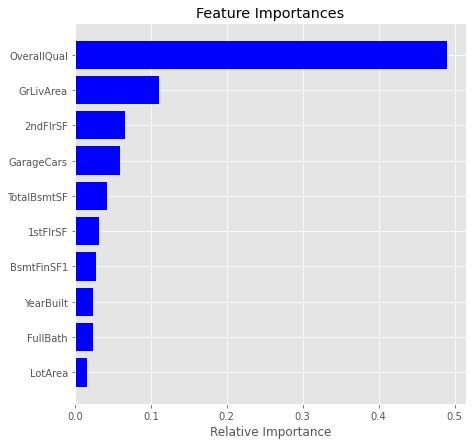

In [19]:
features=X_train.columns
importances = model.feature_importances_
indices=np.argsort(importances)
num_features = 10 

plt.figure(figsize=(7,7))
plt.title('Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features),[features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()




*  Boosting Stage




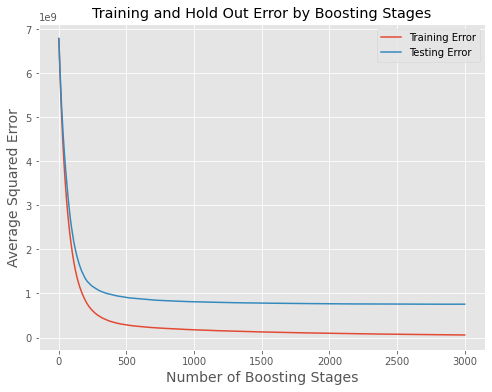

In [20]:
N_ESTIMATORS = 3000
model = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, learning_rate=0.01)
model.fit(X_train, y_train)

train_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict(X_train)):
    train_score[i] = model.loss_(y_train, y_pred)

test_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)
    
plt.plot(np.arange(N_ESTIMATORS) + 1, train_score,
        label="Training Error")
plt.plot(np.arange(N_ESTIMATORS) + 1, test_score,
        label="Testing Error")
plt.title("Training and Hold Out Error by Boosting Stages")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)
plt.legend(loc="upper right")




* Estimating the optimal number of boosters 




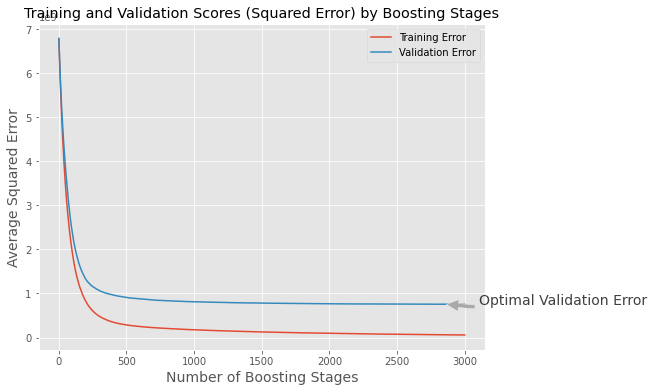

In [22]:


optimal_n_trees = np.argmin(test_score)
optimal_score = test_score[optimal_n_trees]

plt.plot(np.arange(N_ESTIMATORS) + 1, train_score,
        label="Training Error")
plt.plot(np.arange(N_ESTIMATORS) + 1, test_score,
        label="Validation Error")

optimal_point = (optimal_n_trees, optimal_score)
plt.annotate('Optimal Validation Error', optimal_point,
              xytext=(optimal_point[0] + 250, optimal_point[1] + 3),
              arrowprops=dict(facecolor="darkgrey", shrink=0.05),
              fontsize=14,
              alpha=0.75
            )

plt.title("Training and Validation Scores (Squared Error) by Boosting Stages")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)
plt.legend(loc="upper right")


In [23]:
model = GradientBoostingRegressor(n_estimators=optimal_n_trees, learning_rate=0.01)
model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=2853)



*   Élément de liste




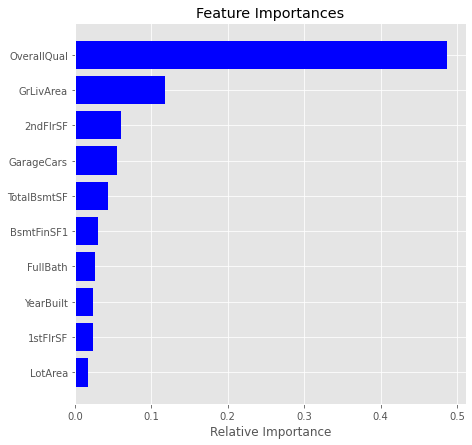

In [25]:
features=X_train.columns
importances = model.feature_importances_
indices=np.argsort(importances)
num_features = 10 

plt.figure(figsize=(7,7))
plt.title('Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features),[features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()



*   Tuning by cross validation




In [26]:
from sklearn.model_selection import cross_validate as cv

In [27]:
N_ESTIMATORS = 1000
N_FOLDS = 5

train_scores = np.zeros((N_FOLDS, N_ESTIMATORS))
test_scores = np.zeros((N_FOLDS, N_ESTIMATORS))

fold = KFold(N_FOLDS,shuffle=True,random_state=1) 

for k, (train_idxs, test_idxs) in enumerate(fold.split(X)):
    X_train, y_train = X.iloc[train_idxs], y.iloc[train_idxs]
    X_test, y_test = X.iloc[test_idxs, :], y.iloc[test_idxs]
    model = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, learning_rate=0.01)
    model.fit(X_train, y_train)
    for i, y_pred in enumerate(model.staged_predict(X_train)):
        train_scores[k, i] = model.loss_(y_train, y_pred)
    for i, y_pred in enumerate(model.staged_predict(X_test)):
        test_scores[k, i] = model.loss_(y_test, y_pred)
        
mean_train_score = np.mean(train_scores, axis=0)
mean_test_score = np.mean(test_scores, axis=0)

optimal_n_trees = np.argmin(mean_test_score)
optimal_score = mean_test_score[optimal_n_trees]
optimal_point = (optimal_n_trees, optimal_score)

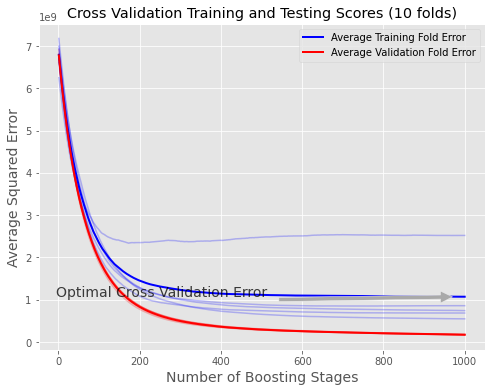

In [28]:
for i in range(N_FOLDS):
    plt.plot(np.arange(N_ESTIMATORS) + 1, train_scores[i, :], color='red', alpha=0.25)
    
for i in range(N_FOLDS):
    plt.plot(np.arange(N_ESTIMATORS) + 1, test_scores[i, :], color='blue', alpha=0.25)
    
plt.plot(np.arange(N_ESTIMATORS) + 1, mean_test_score, color='blue', linewidth=2,
         label='Average Training Fold Error')
plt.plot(np.arange(N_ESTIMATORS) + 1, mean_train_score, color='red', linewidth=2,
         label='Average Validation Fold Error')

plt.annotate('Optimal Cross Validation Error', optimal_point,
              xytext=(optimal_point[0] - 1000, optimal_point[1] + 3),
              arrowprops=dict(facecolor="darkgrey", shrink=0.05),
              fontsize=14,
              alpha=0.75
            )

plt.title("Cross Validation Training and Testing Scores (10 folds)")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)
plt.legend(loc="upper right")






*   Lrate



Text(0.5, 0.98, 'Effect of Varying the Learning Rate')

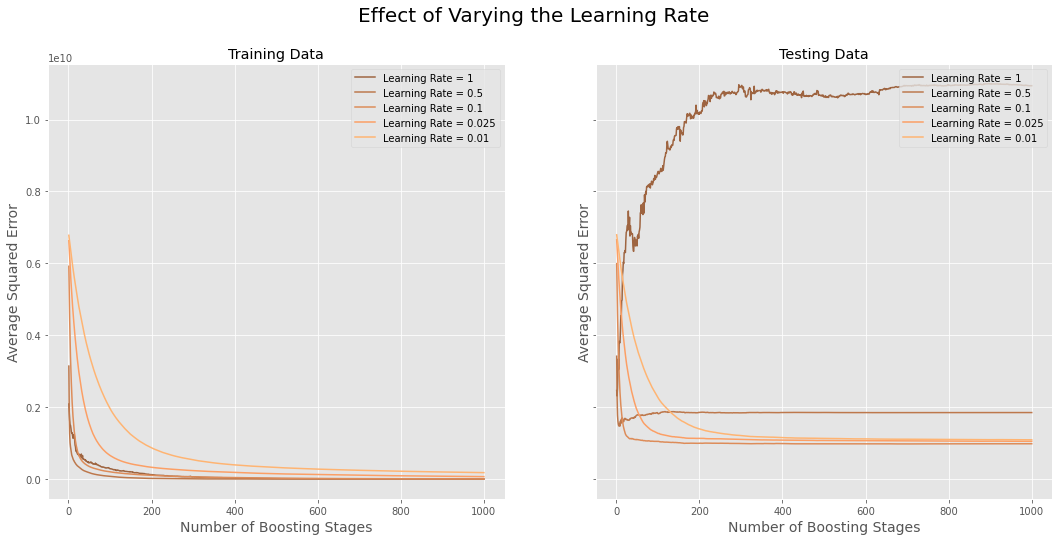

In [30]:
N_ESTIMATORS = 1000
N_FOLDS = 5

learning_rates = [1, 0.5, 0.1, 0.025, 0.01]
N_LEARNING_RATES = len(learning_rates)

train_scores = np.zeros((N_FOLDS, N_LEARNING_RATES, N_ESTIMATORS))
test_scores = np.zeros((N_FOLDS, N_LEARNING_RATES, N_ESTIMATORS))



for k, (train_idxs, test_idxs) in enumerate(fold.split(X)):
    X_train, y_train = X.iloc[train_idxs], y.iloc[train_idxs]
    X_test, y_test = X.iloc[test_idxs, :], y.iloc[test_idxs]

    models = [GradientBoostingRegressor(n_estimators=N_ESTIMATORS,
                                        max_depth=3, learning_rate=lr, subsample=0.5,
                                        random_state=154) 
              for lr in learning_rates]
    for model in models:
        model.fit(X_train, y_train)
    
    for i, model in enumerate(models):
        for j, y_pred in enumerate(model.staged_predict(X_train)):
            train_scores[k, i, j] = model.loss_(y_train, y_pred)
        
    for i, model in enumerate(models):
        for j, y_pred in enumerate(model.staged_predict(X_test)):
            test_scores[k, i, j] = model.loss_(y_test, y_pred)

mean_train_scores = np.mean(train_scores, axis=0)
mean_test_scores = np.mean(test_scores, axis=0)
            
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, 
                         figsize=(18.0, 8.0))
        
for i, rate in enumerate(learning_rates):        
    axes[0].plot(np.arange(N_ESTIMATORS) + 1, mean_train_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Learning Rate = " + str(rate))
axes[0].legend(loc="upper right")
axes[0].set_title("Training Data")
axes[0].set_xlabel('Number of Boosting Stages', fontsize=14)
axes[0].set_ylabel('Average Squared Error', fontsize=14)

for i, rate in enumerate(learning_rates):        
    axes[1].plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Learning Rate = " + str(rate))
axes[1].legend(loc="upper right")
axes[1].set_title("Testing Data")
axes[1].set_xlabel('Number of Boosting Stages', fontsize=14)
axes[1].set_ylabel('Average Squared Error', fontsize=14)


plt.suptitle("Effect of Varying the Learning Rate", fontsize=20)


Lrearning=0.1 seems to give the best everage squared error 